Every third comment on the heatmap of French fertility trends I posted to Reddit earlier today was some variation on inferring the timing of conceptions from seasonality in births (expressed in more direct language). In this post I'm going to meet Reddit users where they are by visualizing how the timing of conceptions leading to births varies across the United States.

Links to articles:
https://www.smithsonianmag.com/science-nature/more-babies-are-conceived-during-winter-fall-180971112/
https://www.bu.edu/articles/2020/best-time-to-get-pregnant-for-americans
https://pmc.ncbi.nlm.nih.gov/articles/PMC8204656/

https://link.springer.com/article/10.1007/s42379-023-00140-5
https://link.springer.com/article/10.1038/s41598-022-22159-3

https://genomeofindia.substack.com/p/wake-me-up-when-august-ends

In [24]:
import polars as pl
# show all table rows
pl.Config.set_tbl_rows(-1);




In [ ]:
wonder_data_path = 'monthly-births-by-state-2007-2024.csv'

births = pl.read_csv(wonder_data_path, infer_schema_length=100000)
# remove footer and total rows
births = births.filter(pl.col('State').is_not_null(), pl.col('Notes').is_null()).drop('Notes')
# add datetime column so we can get days in each month (including leap years etc.)
births = births.with_columns(
    pl.date(pl.col('Year'), pl.col('Month Code'), 1).alias('Date')
).with_columns(
    pl.col('Date').dt.days_in_month().alias('days_in_month')
).sort('State', 'Date').with_columns(
    (pl.col('Births') / (30 / pl.col('days_in_month'))).alias('births_adj')
).with_columns(
    pl.col('births_adj').shift(-9).over('State').alias('conceptions_adj'),
    # this dataset only includes full years, so we don't need to worry about partial years
    pl.col('births_adj').sum().over(['State', 'Year']).alias('annual_births_adj')
).with_columns(
    pl.col('conceptions_adj').sum().over(['State', 'Year']).alias('annual_conceptions_adj')
).filter(
    # include only full years
    (pl.col('conceptions_adj').is_null().sum().over(['State', 'Year']) == 0)
).with_columns(
    (pl.col('conceptions_adj') / pl.col('annual_conceptions_adj')).alias('share_of_conceptions')
)

births.tail(12)



State,State Code,Year,Year Code,Month,Month Code,Births,Date,days_in_month,births_adj,conceptions_adj,annual_births_adj,annual_conceptions_adj,share_of_conceptions
str,i64,i64,i64,str,i64,i64,date,i8,f64,f64,f64,f64,f64
"""Wyoming""",56,2023,2023,"""January""",1,459,2023-01-01,31,474.3,518.733333,6078.233333,6169.966667,0.084074
"""Wyoming""",56,2023,2023,"""February""",2,449,2023-02-01,28,419.066667,469.0,6078.233333,6169.966667,0.076013
"""Wyoming""",56,2023,2023,"""March""",3,536,2023-03-01,31,553.866667,487.733333,6078.233333,6169.966667,0.07905
"""Wyoming""",56,2023,2023,"""April""",4,498,2023-04-01,30,498.0,499.1,6078.233333,6169.966667,0.080892
"""Wyoming""",56,2023,2023,"""May""",5,510,2023-05-01,31,527.0,470.766667,6078.233333,6169.966667,0.0763
"""Wyoming""",56,2023,2023,"""June""",6,544,2023-06-01,30,544.0,542.5,6078.233333,6169.966667,0.087926
"""Wyoming""",56,2023,2023,"""July""",7,514,2023-07-01,31,531.133333,526.0,6078.233333,6169.966667,0.085252
"""Wyoming""",56,2023,2023,"""August""",8,552,2023-08-01,31,570.4,542.5,6078.233333,6169.966667,0.087926
"""Wyoming""",56,2023,2023,"""September""",9,485,2023-09-01,30,485.0,526.0,6078.233333,6169.966667,0.085252


In [28]:
# average monthly share of conceptions across years
births_agg = births.group_by(['State', 'Month', 'Month Code']).agg(
    pl.col('share_of_conceptions').mean().alias('share_of_conceptions')
).sort('State', 'Month Code').with_columns(
    (pl.col('share_of_conceptions') - pl.col('share_of_conceptions').min().over('State')).alias('excess_share_conceptions')
)

births_agg.head(12)

State,Month,Month Code,share_of_conceptions,excess_share_conceptions
str,str,i64,f64,f64
"""Alabama""","""January""",1,0.087264,0.016243
"""Alabama""","""February""",2,0.081469,0.010447
"""Alabama""","""March""",3,0.087903,0.016881
"""Alabama""","""April""",4,0.084919,0.013898
"""Alabama""","""May""",5,0.071022,0.0
"""Alabama""","""June""",6,0.082779,0.011757
"""Alabama""","""July""",7,0.076274,0.005252
"""Alabama""","""August""",8,0.081437,0.010416
"""Alabama""","""September""",9,0.080515,0.009494


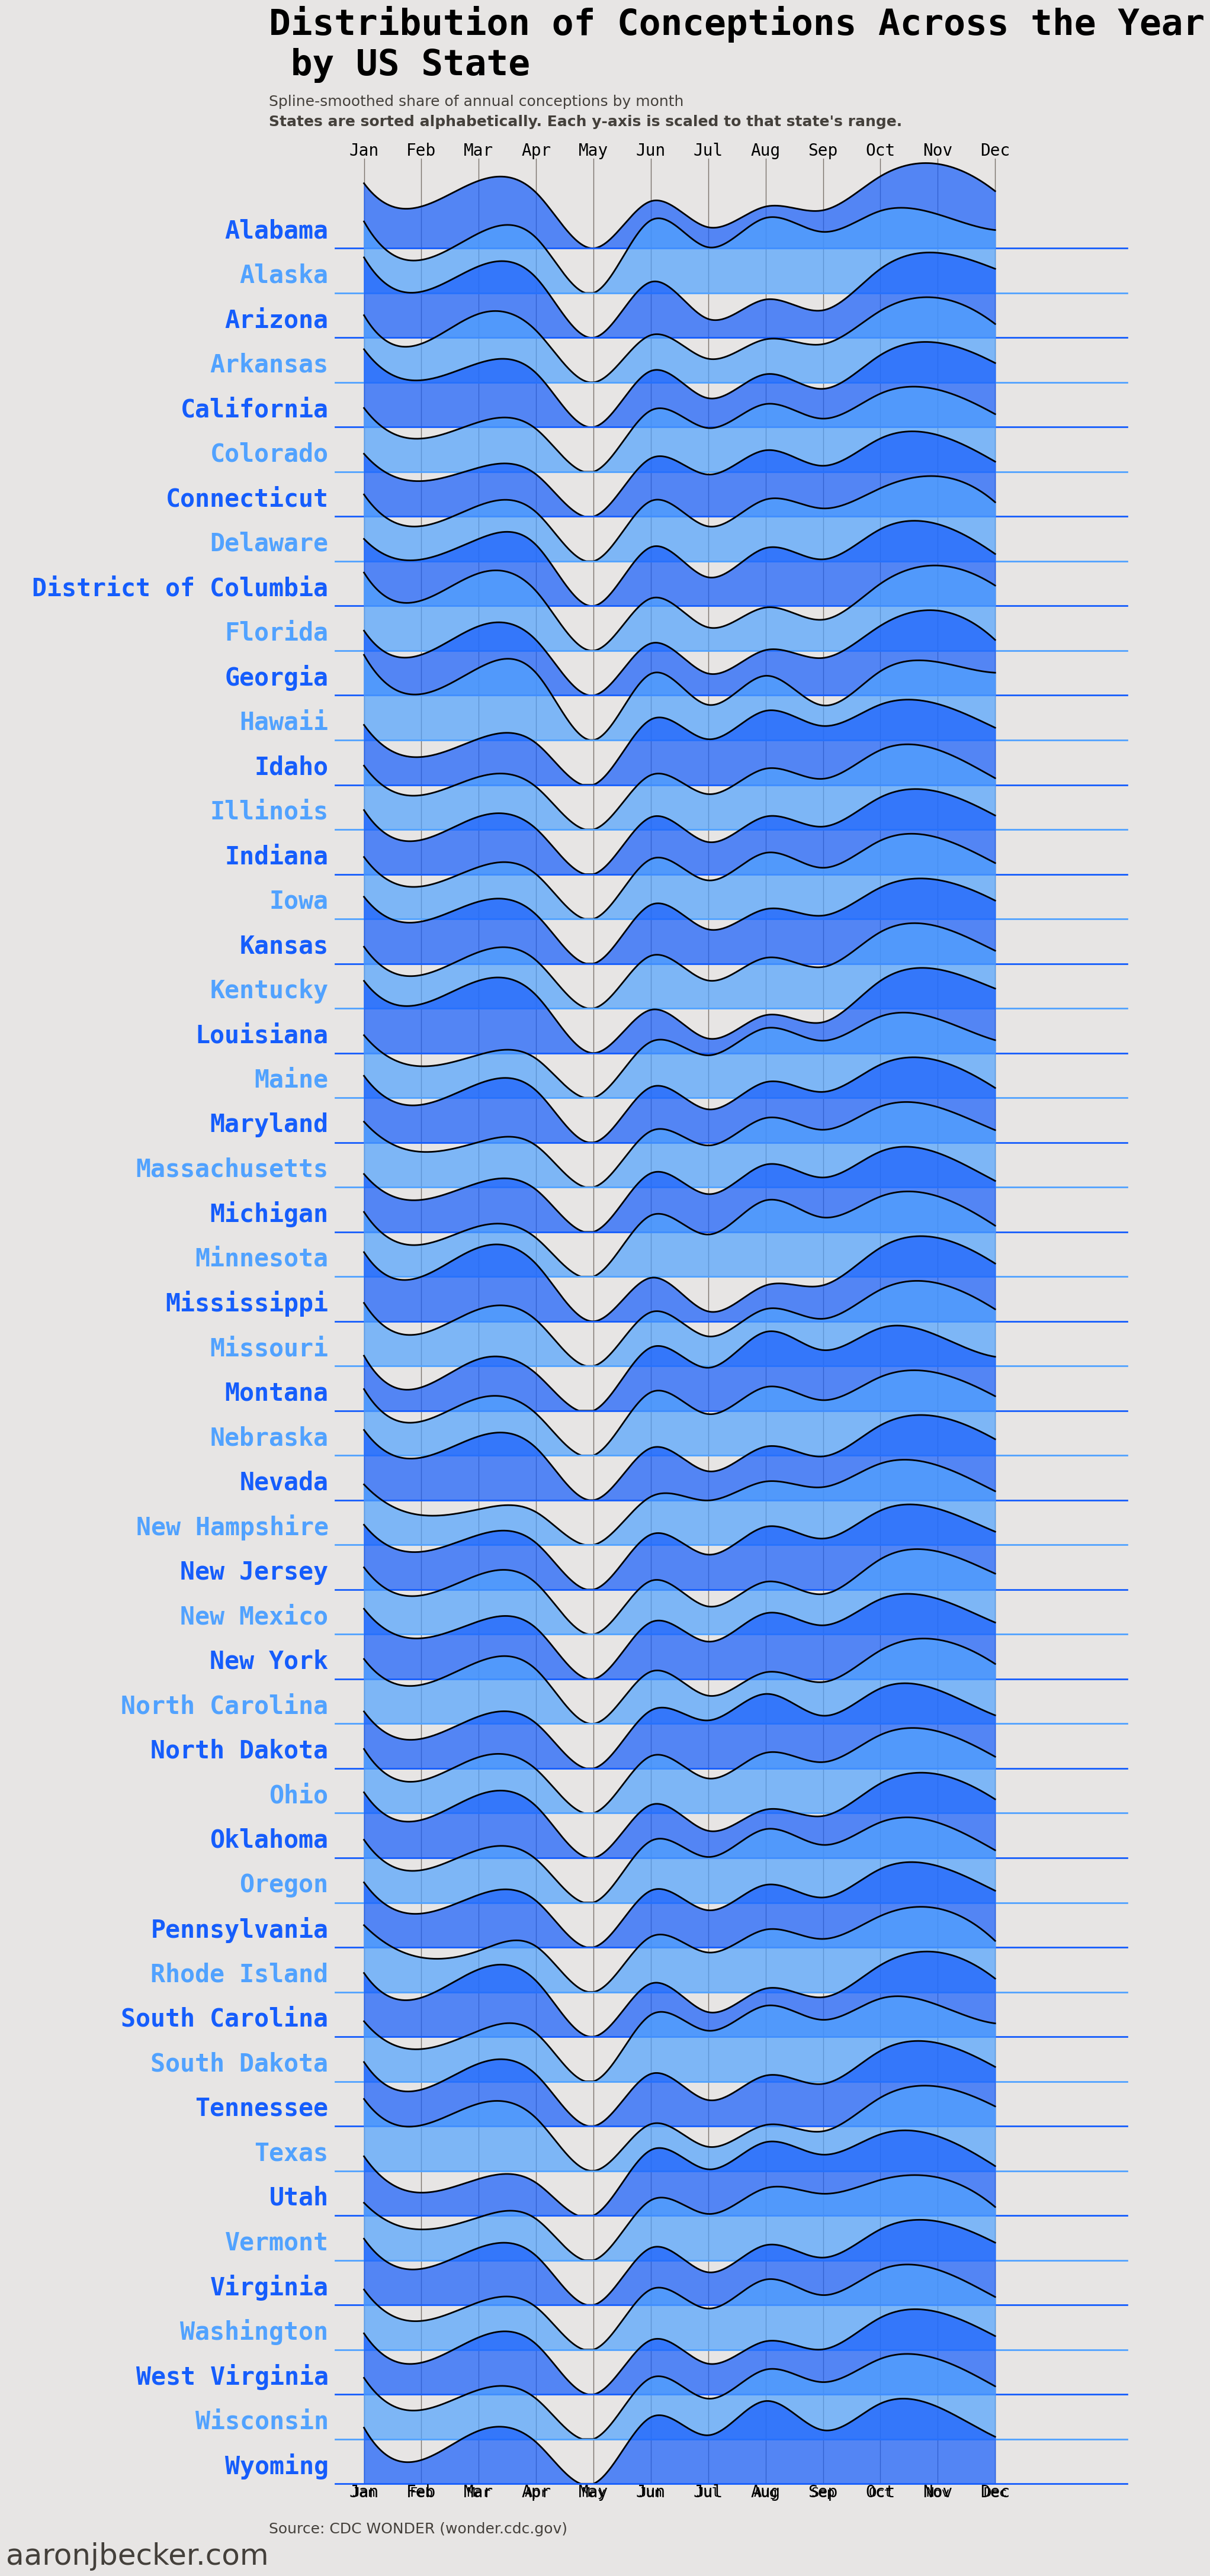

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import transforms
from scipy.interpolate import UnivariateSpline
import numpy as np

variable = 'excess_share_conceptions'

# customize font in visualizations
mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.facecolor'] = '#fafaf9'

# Convert to pandas for easier matplotlib integration
df = births_agg.to_pandas()

# Get unique states, sorted alphabetically
states = sorted(df['State'].unique())
n_states = len(states)
height = 1.0

# Create figure with subplots
fig, axes = plt.subplots(n_states, 1, figsize=(15, height * n_states), 
                        facecolor=(0, 0, 0, 0), sharex=True, sharey=False)

fig.set_facecolor('#e7e5e4')

# Colors for alternating states
even_color = '#155dfc'
odd_color = '#51a2ff'
grid_color = '#79716b'

# Create x-axis values for months (1-12)
x_months = np.linspace(1, 12, 1000)  # Smooth curve across the year

# Plot each state
for idx, state in enumerate(states):
    ax = axes[idx]
    
    # Get data for this state, sorted by month code
    state_data = df[df['State'] == state].sort_values('Month Code')
    months = state_data['Month Code'].values
    shares = state_data[variable].values
    
    # Create smooth spline interpolation from the 12 monthly data points
    # Use a smoothing spline with a small smoothing factor for smooth curves
    spline = UnivariateSpline(months, shares, s=0, k=3)  # s=0 means no smoothing, k=3 is cubic
    
    # Evaluate spline over smooth x-axis
    smoothed_shares = spline(x_months)
    
    # Ensure values don't go below 0 (since we're showing excess share)
    smoothed_shares = np.maximum(smoothed_shares, 0)
    
    # Get color for this state
    if idx % 2 == 0:
        color = even_color
    else:
        color = odd_color
    
    # Fill the area under the curve
    ax.fill_between(x_months, 0, smoothed_shares, color=color, alpha=0.7, zorder=1)
    
    # Plot the line in black
    ax.plot(x_months, smoothed_shares, color='black', linewidth=2, zorder=2)
    
    # Add horizontal reference line at y=0
    blended_transform = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.plot([0, 1.15], [0, 0], linewidth=2, linestyle='-', color=color, 
            clip_on=False, transform=blended_transform)
    
    # Add state label to the left
    ax.text(-0.01, 0.2, state, fontweight='bold', color=color, fontsize=30,
            ha='right', va='center', transform=ax.transAxes)
    
    # Remove unnecessary axes details
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set transparent background
    ax.set_facecolor((0, 0, 0, 0))
    
    # Hide x-axis tick marks
    ax.tick_params(axis='x', which='major', length=0, width=0, labelsize=0)
    
    # Set x-axis limits to show full year
    ax.set_xlim(0.5, 12.5)
    
    # Set y-axis minimum to 0 so curves touch the axis
    ax.set_ylim(bottom=0)

# Set the subplots to overlap
fig.subplots_adjust(hspace=-0.5)

# Set x-axis ticks and labels for months
reference_ax = axes[-1]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
reference_ax.set_xticks(range(1, 13))
reference_ax.set_xticklabels(month_names, fontsize=16)

# Get bounding boxes for positioning labels
top_ax = axes[0]
bottom_ax = axes[-1]

top_bbox = top_ax.get_position()
bottom_bbox = bottom_ax.get_position()

top_y = top_bbox.y1
bottom_y = bottom_bbox.y0

# Create blended transforms for positioning labels
top_transform = transforms.blended_transform_factory(
    top_ax.transData,
    fig.transFigure
)
bottom_transform = transforms.blended_transform_factory(
    bottom_ax.transData,
    fig.transFigure
)

# Add month labels at the top
top_label_artists = []
for month_num in range(1, 13):
    text_artist = fig.text(month_num, top_y, month_names[month_num - 1], 
                           ha='center', va='bottom', 
                           transform=top_transform, fontsize=20, color='black')
    top_label_artists.append(text_artist)

# Add month labels at the bottom
bottom_label_artists = []
for month_num in range(1, 13):
    text_artist = fig.text(month_num, bottom_y, month_names[month_num - 1], 
                           ha='center', va='top', 
                           transform=bottom_transform, fontsize=20, color='black')
    bottom_label_artists.append(text_artist)

# Draw grid lines on the figure level
fig.canvas.draw()
grid_top_y = None
grid_bottom_y = None

if top_label_artists:
    renderer = fig.canvas.get_renderer()
    top_label_bbox_display = top_label_artists[0].get_window_extent(renderer=renderer)
    fig_bbox_display = fig.get_window_extent()
    top_label_bottom_display = top_label_bbox_display.y0
    top_label_bottom_fig = (top_label_bottom_display - fig_bbox_display.y0) / fig_bbox_display.height
    grid_top_y = top_label_bottom_fig
else:
    grid_top_y = top_y - 0.015

if bottom_label_artists:
    renderer = fig.canvas.get_renderer()
    bottom_label_bbox_display = bottom_label_artists[0].get_window_extent(renderer=renderer)
    fig_bbox_display = fig.get_window_extent()
    bottom_label_top_display = bottom_label_bbox_display.y1
    bottom_label_top_fig = (bottom_label_top_display - fig_bbox_display.y0) / fig_bbox_display.height
    grid_bottom_y = bottom_label_top_fig
else:
    grid_bottom_y = bottom_y + 0.015

# Create blended transform for drawing grid lines
grid_transform = transforms.blended_transform_factory(
    reference_ax.transData,
    fig.transFigure
)

# Draw vertical grid lines at each month
from matplotlib.lines import Line2D
for month_num in range(1, 13):
    line = Line2D([month_num, month_num], [grid_bottom_y, grid_top_y], 
                  color=grid_color, linewidth=1, alpha=1, zorder=-10,
                  transform=grid_transform, clip_on=False)
    fig.add_artist(line)

# Add title and subtitle
mainTitle = 'Distribution of Conceptions Across the Year\n by US State'
subtitle = 'Spline-smoothed share of annual conceptions by month'
subtitle2 = 'States are sorted alphabetically. Each y-axis is scaled to that state\'s range.'

# Top text
text = fig.text(0.05, grid_top_y + 0.01, subtitle2, fontsize=18, ha='left', 
                fontfamily='sans-serif', color='#44403b', fontweight='bold', va='bottom')
ex = text.get_window_extent()
x, y = text.get_position()
t = transforms.offset_copy(text._transform, y=ex.height + 10, units='dots')
text = fig.text(x, y, subtitle, transform=t, va='bottom', fontfamily='sans-serif', 
                fontsize=18, color='#44403b')
ex = text.get_window_extent()
x, y = text.get_position()
t = transforms.offset_copy(text._transform, y=ex.height + 20, units='dots')
text = fig.text(x, y, mainTitle, transform=t, va='bottom', fontsize=44, fontweight='bold')

# Bottom text
text = fig.text(0.05, grid_bottom_y - 0.0125, 
    "Source: CDC WONDER (wonder.cdc.gov)", fontsize=18, ha='left', 
    fontfamily='sans-serif', color='#44403b', va='top')
ex = text.get_window_extent()
x, y = text.get_position()
t = transforms.offset_copy(text._transform, y=-ex.height - 10, units='dots')
text = fig.text(x, y, "aaronjbecker.com", fontsize=36, ha='right', va='top', 
                transform=t, fontfamily='sans-serif', color='#44403b')

plt.show()
